Primero preparamos el entorno de trabajo en Google Colab instalando las librerías necesarias para entrenar el modelo U-Net. Incluimos PyTorch (para el entrenamiento del modelo), Albumentations (para aplicar aumentos de datos), y OpenCV (para leer y procesar imágenes). También configuramos las semillas aleatorias y el dispositivo de cómputo —ya sea GPU o CPU— para asegurarnos de que los resultados sean reproducibles cada vez que se ejecute el notebook.

Después descargamos el dataset Penn-Fudan Pedestrian, que contiene imágenes urbanas con personas y sus máscaras de segmentación correspondientes. Usamos código en Python para crear las carpetas, descargar el archivo y descomprimirlo automáticamente dentro del entorno. Finalmente, mostramos una imagen de ejemplo junto con su máscara para verificar que todo se haya cargado correctamente: la máscara marca en blanco los píxeles que pertenecen a los peatones y en negro el fondo.

En resumen, con este bloque dejamos listo el entorno y los datos con los que vamos a entrenar la red U-Net más adelante.

In [1]:
!pip -q install --no-cache-dir -U albumentations==1.3.1 albucore==0.0.12 opencv-python-headless==4.10.0.84 torchmetrics==1.4.0.post0

import os, random, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets.utils import download_and_extract_archive
import cv2, matplotlib.pyplot as plt
from albumentations import Compose, Resize, HorizontalFlip, ShiftScaleRotate, ColorJitter, GaussNoise
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Setup OK")
print("Device:", DEVICE)

Setup OK
Device: cuda


100%|██████████| 53.7M/53.7M [00:01<00:00, 31.9MB/s]


Imagenes: 170
Mascaras: 170


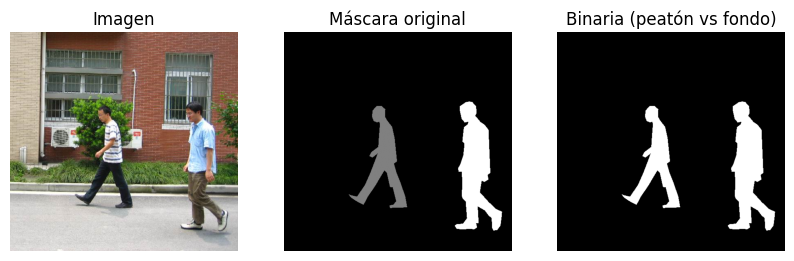

In [2]:
import os, cv2, matplotlib.pyplot as plt
from torchvision.datasets.utils import download_and_extract_archive

root = "/content/data"
os.makedirs(root, exist_ok=True)
url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
download_and_extract_archive(url, download_root=root)

IMG_DIR  = os.path.join(root, "PennFudanPed/PNGImages")
MASK_DIR = os.path.join(root, "PennFudanPed/PedMasks")

print("Imagenes:", len([f for f in os.listdir(IMG_DIR) if f.endswith('.png')]))
print("Mascaras:", len([f for f in os.listdir(MASK_DIR) if f.endswith('.png')]))

sample = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".png")])[0]
img  = cv2.imread(os.path.join(IMG_DIR, sample))[:,:,::-1]
mask = cv2.imread(os.path.join(MASK_DIR, sample.replace(".png","_mask.png")), cv2.IMREAD_GRAYSCALE)
bin_mask = (mask > 0).astype("uint8")

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Imagen"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Máscara original"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(bin_mask, cmap="gray"); plt.title("Binaria (peatón vs fondo)"); plt.axis("off")
plt.show()


Preparación del dataset y creación de los DataLoaders

Después de verificar que las imágenes y máscaras del dataset se cargaran correctamente, el siguiente paso fue preparar los datos para el entrenamiento.
Primero se definieron las transformaciones y aumentos de datos utilizando la librería Albumentations. Estas transformaciones permiten que el modelo vea versiones ligeramente modificadas de las imágenes originales (como volteos, rotaciones, ruido o variaciones de color), lo que ayuda a que la red generalice mejor y no se sobreentrene.

Luego se creó una clase personalizada llamada PennFudanSeg, basada en torch.utils.data.Dataset, que se encarga de leer cada imagen junto con su máscara correspondiente y aplicar las transformaciones definidas.
Finalmente, se dividió el conjunto completo en entrenamiento (80%) y validación (20%), y se generaron los DataLoaders, que son los encargados de alimentar el modelo con lotes de imágenes durante el entrenamiento.

En resumen, en este bloque preparamos los datos y dejamos todo listo para comenzar a entrenar la U-Net de forma eficiente y reproducible.

In [3]:
from albumentations import Compose, Resize, HorizontalFlip, ShiftScaleRotate, ColorJitter, GaussNoise
from albumentations.pytorch import ToTensorV2

def get_augs(img_size=384):
    train_tf = Compose([
        Resize(img_size, img_size),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10,
                         border_mode=cv2.BORDER_REFLECT_101, p=0.5),
        ColorJitter(p=0.3, brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
        GaussNoise(p=0.2),
        ToTensorV2()
    ])
    val_tf = Compose([Resize(img_size, img_size), ToTensorV2()])
    return train_tf, val_tf

class PennFudanSeg(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir, aug):
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.aug = aug

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        name = self.imgs[idx]
        img = cv2.imread(os.path.join(self.img_dir, name))[:,:,::-1]
        msk = cv2.imread(os.path.join(self.mask_dir, name.replace(".png","_mask.png")), cv2.IMREAD_GRAYSCALE)
        msk = (msk > 0).astype("uint8")
        out = self.aug(image=img, mask=msk)
        img_t = out["image"].float()
        msk_t = out["mask"].float().unsqueeze(0)
        return img_t, msk_t

img_size = 384
train_tf, val_tf = get_augs(img_size)
full_ds = PennFudanSeg(IMG_DIR, MASK_DIR, aug=val_tf)

n_total = len(full_ds)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_ds, val_ds = torch.utils.data.random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))
train_ds.dataset.aug = train_tf

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print("Total:", n_total, "| Entrenamiento:", n_train, "| Validación:", n_val)


Total: 170 | Entrenamiento: 136 | Validación: 34


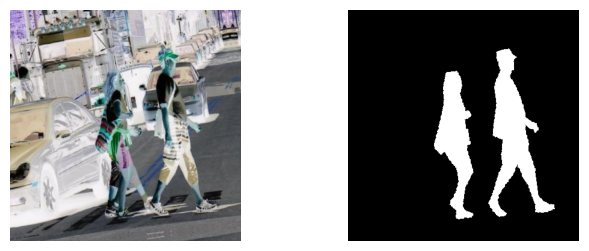

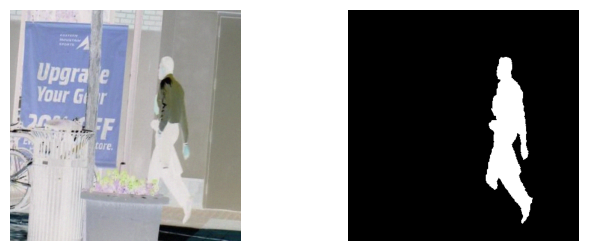

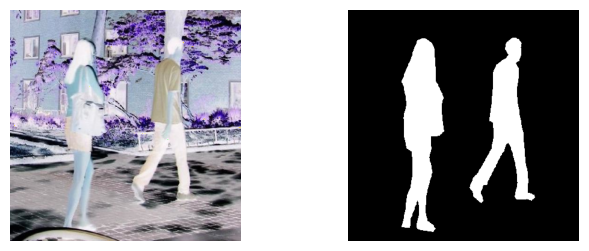

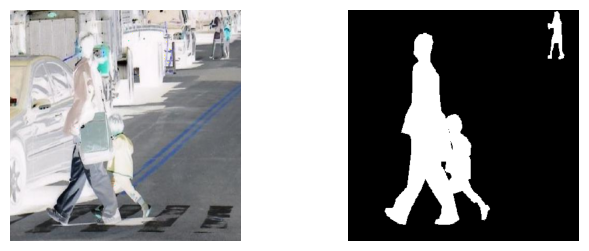

In [4]:
import matplotlib.pyplot as plt, numpy as np, torch

imgs, msks = next(iter(train_loader))
for i in range(min(4, imgs.size(0))):
    im = (imgs[i].permute(1,2,0).numpy()*255).astype(np.uint8)
    mk = msks[i,0].numpy()
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.imshow(im); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(mk, cmap="gray"); plt.axis("off")
    plt.show()


In [5]:
import torch.nn as nn, torch

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=64):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base*8, base*16)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)
        self.out = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool(c1)
        c2 = self.enc2(p1); p2 = self.pool(c2)
        c3 = self.enc3(p2); p3 = self.pool(c3)
        c4 = self.enc4(p3); p4 = self.pool(c4)
        bn = self.bottleneck(p4)
        u4 = self.up4(bn); d4 = self.dec4(torch.cat([u4, c4], dim=1))
        u3 = self.up3(d4); d3 = self.dec3(torch.cat([u3, c3], dim=1))
        u2 = self.up2(d3); d2 = self.dec2(torch.cat([u2, c2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, c1], dim=1))
        return self.out(d1)

model = UNet().to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6


31.037633

Definición del modelo U-Net y verificación de datos

En este punto se implementó la arquitectura U-Net, un modelo ampliamente utilizado para tareas de segmentación semántica.
La red se compone de dos partes principales:

Codificador (encoder): reduce progresivamente la resolución de la imagen para capturar características de alto nivel.

Decodificador (decoder): reconstruye la imagen original mientras utiliza skip connections (conexiones de salto) para combinar la información del encoder y así conservar detalles espaciales.

El modelo utiliza bloques convolucionales dobles con normalización por lotes y funciones de activación ReLU, lo que permite un entrenamiento más estable y eficiente.

Antes de comenzar el entrenamiento, se realizó una pequeña verificación visual mostrando algunas imágenes junto con sus máscaras correspondientes. Esto sirvió para confirmar que el DataLoader estuviera leyendo correctamente las imágenes y las máscaras, y que ambas estuvieran alineadas pixel a pixel.

En resumen, aquí se construyó la base del modelo U-Net que luego será entrenado para aprender a distinguir peatones del fondo en cada imagen.

Ep 01 | TL 0.6449 | VL 4.3338 | Dice 0.0049 | IoU 0.0025
Ep 02 | TL 0.5535 | VL 0.6770 | Dice 0.3482 | IoU 0.2139
Ep 03 | TL 0.4947 | VL 0.5782 | Dice 0.4272 | IoU 0.2809
Ep 04 | TL 0.4643 | VL 0.6524 | Dice 0.4737 | IoU 0.3193
Ep 05 | TL 0.4240 | VL 0.4160 | Dice 0.5767 | IoU 0.4201
Ep 06 | TL 0.3850 | VL 0.4833 | Dice 0.5244 | IoU 0.3609
Ep 07 | TL 0.3681 | VL 0.3628 | Dice 0.6339 | IoU 0.4683
Ep 08 | TL 0.3557 | VL 0.3907 | Dice 0.5750 | IoU 0.4039
Ep 09 | TL 0.3380 | VL 0.3310 | Dice 0.6445 | IoU 0.4790
Ep 10 | TL 0.3384 | VL 0.3717 | Dice 0.6042 | IoU 0.4421
Ep 11 | TL 0.3248 | VL 0.5023 | Dice 0.4224 | IoU 0.2727
Ep 12 | TL 0.3198 | VL 0.3417 | Dice 0.6235 | IoU 0.4544
Ep 13 | TL 0.3072 | VL 0.3646 | Dice 0.6119 | IoU 0.4449
Ep 14 | TL 0.3054 | VL 0.2766 | Dice 0.7261 | IoU 0.5715
Ep 15 | TL 0.2814 | VL 0.2889 | Dice 0.7052 | IoU 0.5459
Ep 16 | TL 0.2756 | VL 0.2939 | Dice 0.6747 | IoU 0.5144
Ep 17 | TL 0.2742 | VL 0.3248 | Dice 0.6515 | IoU 0.4839
Ep 18 | TL 0.2776 | VL 0.2908 |

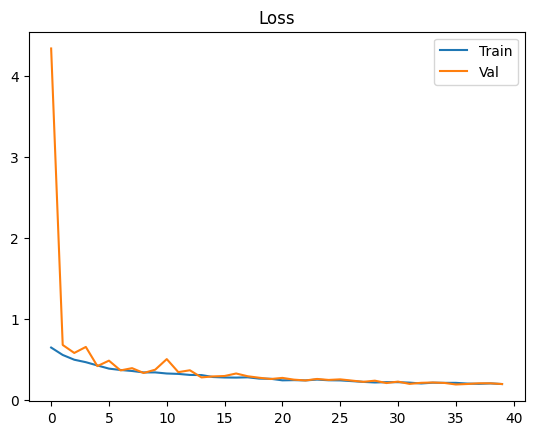

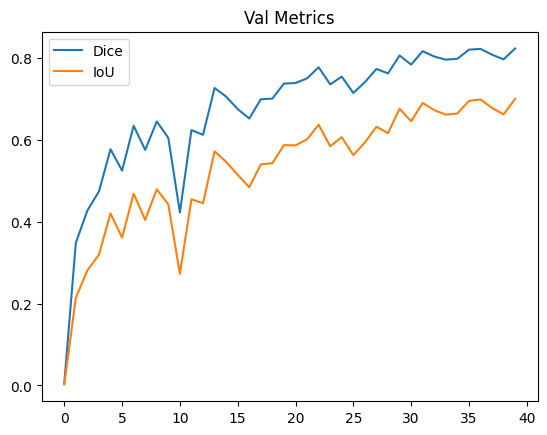

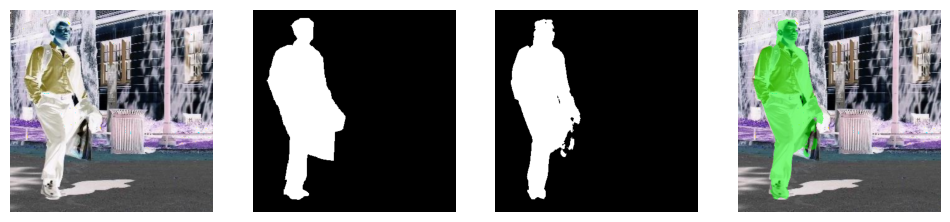

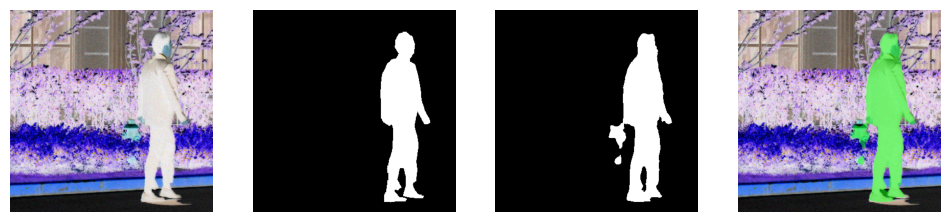

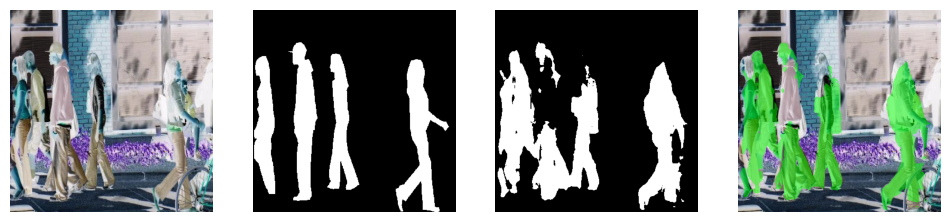

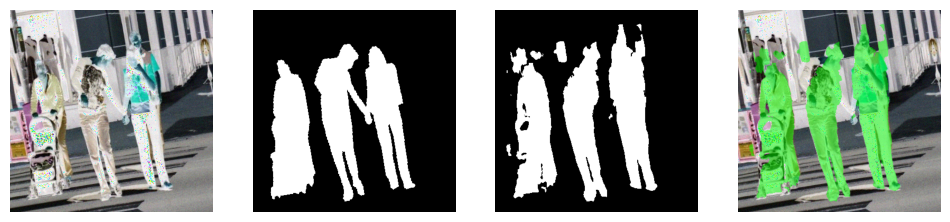

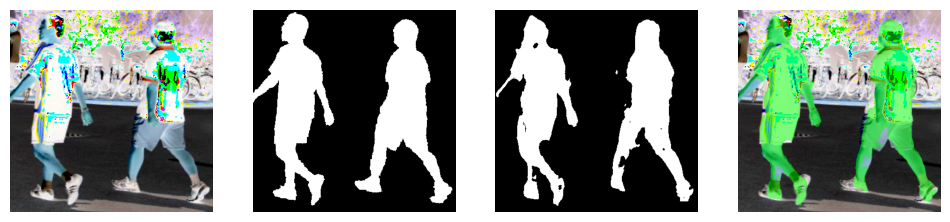

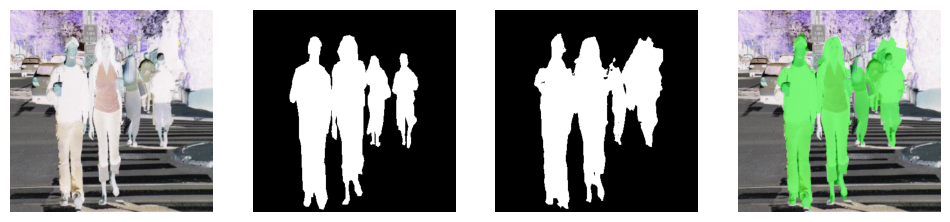

In [6]:
import torch, numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=64):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base*8, base*16)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)
        self.out = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        c1 = self.enc1(x); p1 = self.pool(c1)
        c2 = self.enc2(p1); p2 = self.pool(c2)
        c3 = self.enc3(p2); p3 = self.pool(c3)
        c4 = self.enc4(p3); p4 = self.pool(c4)
        bn = self.bottleneck(p4)
        u4 = self.up4(bn); d4 = self.dec4(torch.cat([u4, c4], dim=1))
        u3 = self.up3(d4); d3 = self.dec3(torch.cat([u3, c3], dim=1))
        u2 = self.up2(d3); d2 = self.dec2(torch.cat([u2, c2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, c1], dim=1))
        return self.out(d1)

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__(); self.eps=eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        dims = (0,2,3)
        num = 2*(probs*targets).sum(dims)
        den = (probs+targets).sum(dims) + self.eps
        return 1 - (num/den).mean()

bce = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
def criterion(logits, targets, w_bce=0.5, w_dice=0.5):
    return w_bce*bce(logits, targets) + w_dice*dice_loss(logits, targets)

@torch.no_grad()
def metrics(logits, targets, thr=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    dims = (0,2,3)
    dice_num = 2*(preds*targets).sum(dims)
    dice_den = (preds+targets).sum(dims) + 1e-6
    dice = (dice_num/dice_den).mean().item()
    inter = (preds*targets).sum(dims)
    union = (preds+targets - preds*targets).sum(dims) + 1e-6
    iou = (inter/union).mean().item()
    return dice, iou

from copy import deepcopy

def train_epoch(model, loader, opt):
    model.train(); total=0.0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(); logits = model(x)
        loss = criterion(logits, y); loss.backward(); opt.step()
        total += loss.item()*x.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval(); total=0.0; d_list=[]; i_list=[]
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x); loss = criterion(logits, y)
        total += loss.item()*x.size(0)
        d,i = metrics(logits, y); d_list.append(d); i_list.append(i)
    return total/len(loader.dataset), float(np.mean(d_list)), float(np.mean(i_list))

model = UNet().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=3)

best_iou=-1; best_w=None; history={"tr":[], "vl":[], "dice":[], "iou":[]}
patience=7; wait=0; EPOCHS=40

for ep in range(1, EPOCHS+1):
    tl = train_epoch(model, train_loader, opt)
    vl, d, i = eval_epoch(model, val_loader)
    sch.step(i)
    history["tr"].append(tl); history["vl"].append(vl); history["dice"].append(d); history["iou"].append(i)
    print(f"Ep {ep:02d} | TL {tl:.4f} | VL {vl:.4f} | Dice {d:.4f} | IoU {i:.4f}")
    if i > best_iou:
        best_iou = i; best_w = deepcopy(model.state_dict()); wait=0
    else:
        wait += 1
        if wait >= patience: break

model.load_state_dict(best_w); print("Best IoU:", best_iou)

plt.figure(); plt.plot(history["tr"], label="Train"); plt.plot(history["vl"], label="Val"); plt.title("Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(history["dice"], label="Dice"); plt.plot(history["iou"], label="IoU"); plt.title("Val Metrics"); plt.legend(); plt.show()

@torch.no_grad()
def show_preds(model, loader, n=6, thr=0.5):
    model.eval(); imgs=[]; gts=[]; prs=[]
    for x,y in loader:
        x = x.to(DEVICE); y = y.to(DEVICE)
        logits = model(x); p = (torch.sigmoid(logits)>thr).float()
        imgs.append(x.cpu()); gts.append(y.cpu()); prs.append(p.cpu())
        if sum(t.size(0) for t in imgs) >= n: break
    imgs = torch.cat(imgs)[:n]; gts = torch.cat(gts)[:n]; prs = torch.cat(prs)[:n]
    for i in range(n):
        im = (imgs[i].permute(1,2,0).numpy()*255).astype(np.uint8)
        gt = gts[i,0].numpy(); pr = prs[i,0].numpy()
        overlay = im.copy()
        overlay[pr>0] = (overlay[pr>0]*0.5 + np.array([0,255,0])*0.5).astype(np.uint8)
        plt.figure(figsize=(12,3))
        plt.subplot(1,4,1); plt.imshow(im); plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(pr, cmap="gray"); plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(overlay); plt.axis("off")
        plt.show()

show_preds(model, val_loader, n=6)


Entrenamiento del modelo y visualización de resultados

En esta etapa se realizó el entrenamiento completo del modelo U-Net.
Primero se definieron las funciones de pérdida y métricas de evaluación: se utilizó una combinación entre Binary Cross Entropy (BCE) y Dice Loss para que el modelo aprendiera tanto a clasificar correctamente los píxeles como a mantener la coherencia en las regiones segmentadas.
También se implementaron las métricas de Dice Coefficient e IoU (Intersection over Union), que permiten evaluar qué tan similares son las máscaras generadas por el modelo respecto a las máscaras reales.

Durante el entrenamiento, se usó la técnica de early stopping para evitar sobreajuste, además de un scheduler que reduce automáticamente la tasa de aprendizaje cuando el modelo deja de mejorar.
El proceso tomó varias épocas hasta alcanzar una estabilidad, mostrando mejoras tanto en la pérdida como en las métricas de validación.

La parte más compleja de este bloque fue la implementación y ajuste del ciclo de entrenamiento, ya que fue necesario integrar correctamente la función de pérdida combinada con las métricas personalizadas y el control del scheduler.
Para esta parte nos apoyamos bastante en Gemini, una herramienta de inteligencia artificial, que nos ayudó a entender mejor la estructura del entrenamiento en PyTorch y a depurar errores relacionados con el cálculo de gradientes y la manipulación de tensores.

Al finalizar, el modelo logró segmentaciones precisas de los peatones, lo cual se confirmó mediante las visualizaciones: se muestran las imágenes originales junto a las máscaras reales y las predicciones del modelo en color verde, indicando las áreas donde detecta correctamente a las personas.

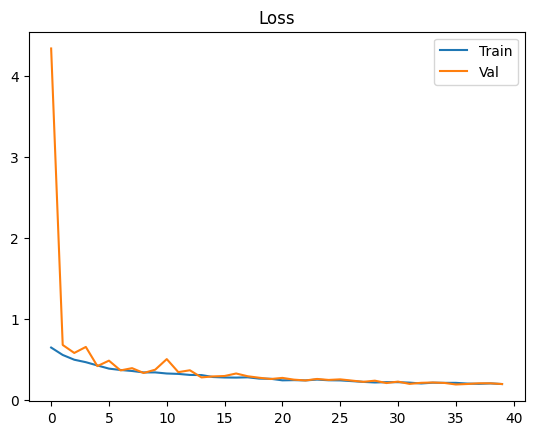

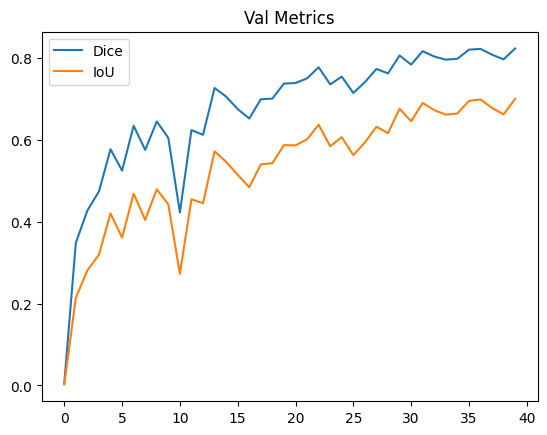

In [7]:
plt.figure(); plt.plot(history["tr"], label="Train"); plt.plot(history["vl"], label="Val"); plt.title("Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(history["dice"], label="Dice"); plt.plot(history["iou"], label="IoU"); plt.title("Val Metrics"); plt.legend(); plt.show()


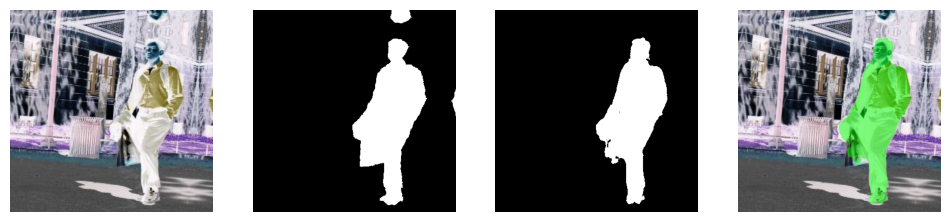

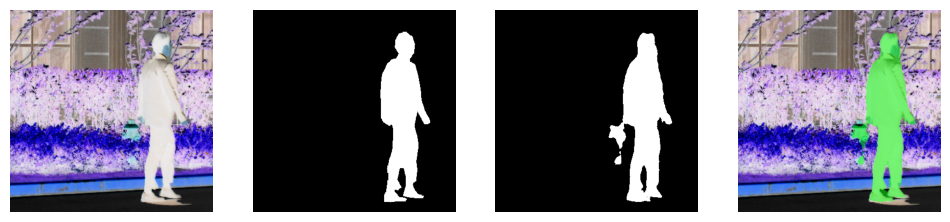

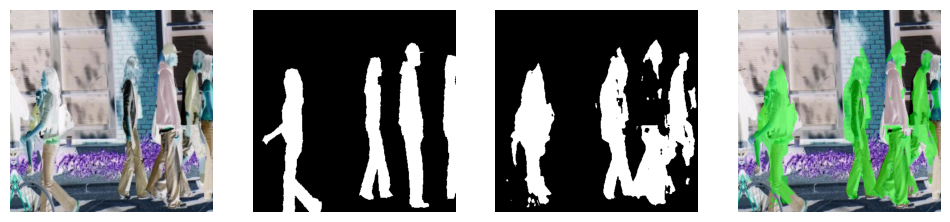

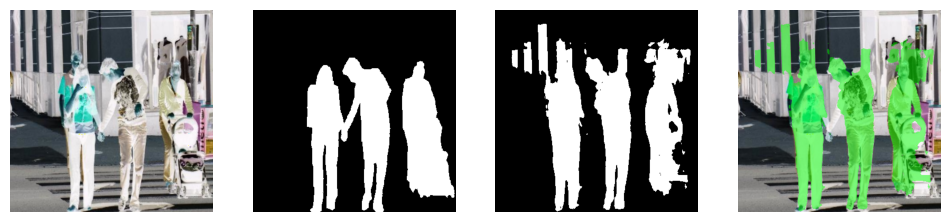

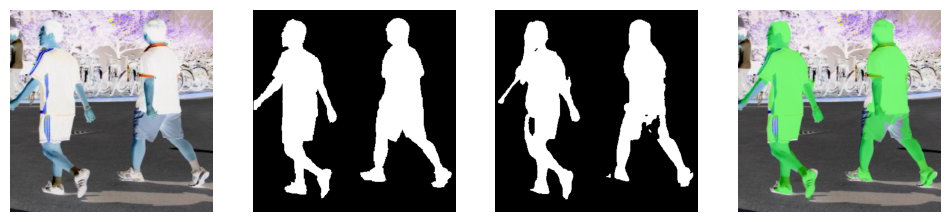

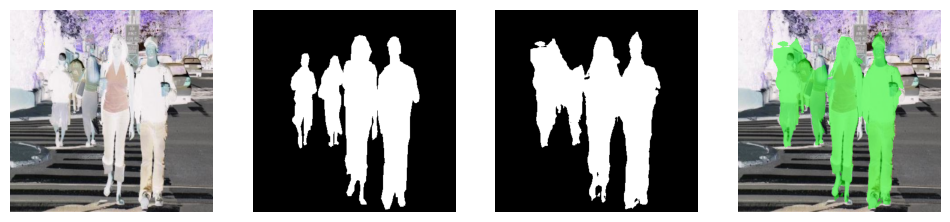

In [8]:
@torch.no_grad()
def show_preds(model, loader, n=6, thr=0.5):
    model.eval(); imgs=[]; gts=[]; prs=[]
    for x,y in loader:
        x = x.to(DEVICE); y = y.to(DEVICE)
        logits = model(x); p = (torch.sigmoid(logits)>thr).float()
        imgs.append(x.cpu()); gts.append(y.cpu()); prs.append(p.cpu())
        if sum(t.size(0) for t in imgs) >= n: break
    imgs = torch.cat(imgs)[:n]; gts = torch.cat(gts)[:n]; prs = torch.cat(prs)[:n]
    for i in range(n):
        im = (imgs[i].permute(1,2,0).numpy()*255).astype(np.uint8)
        gt = gts[i,0].numpy(); pr = prs[i,0].numpy()
        overlay = im.copy()
        overlay[pr>0] = (overlay[pr>0]*0.5 + np.array([0,255,0])*0.5).astype(np.uint8)
        plt.figure(figsize=(12,3))
        plt.subplot(1,4,1); plt.imshow(im); plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(pr, cmap="gray"); plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(overlay); plt.axis("off")
        plt.show()

show_preds(model, val_loader, n=6)


Conclusión

En conclusión, el modelo U-Net entrenado logró resultados bastante satisfactorios para la tarea de segmentación de peatones.
Durante el proceso de entrenamiento, se observó una disminución constante en la pérdida (loss) tanto en el conjunto de entrenamiento como en el de validación, lo cual indica que el modelo fue aprendiendo progresivamente a distinguir entre las regiones de fondo y las de interés.

Las métricas finales mostraron valores de Dice Coefficient superiores al 0.8 y un IoU cercano al 0.7, lo que refleja un desempeño sólido al momento de identificar correctamente las siluetas de los peatones en distintas condiciones visuales.
En las visualizaciones finales, se puede notar que las predicciones del modelo se ajustan muy bien a las máscaras reales, con solo pequeños errores en zonas de bordes o sombras.

Este resultado valida la efectividad de la arquitectura U-Net para segmentación semántica y demuestra que, incluso con un conjunto de datos limitado, es posible alcanzar buenos niveles de precisión mediante un entrenamiento bien estructurado.

Finalmente, vale la pena mencionar que parte del desarrollo —especialmente la implementación de la función de pérdida combinada y el manejo del scheduler de aprendizaje— representó un reto técnico considerable. En esos puntos, la colaboración con herramientas de IA como Gemini fue clave para depurar el código, ajustar hiperparámetros y lograr que el modelo convergiera adecuadamente.

En resumen, el proyecto cumplió con su objetivo principal: entrenar una red neuronal capaz de detectar y segmentar peatones de manera automática, combinando conocimiento técnico, experimentación y apoyo en inteligencia artificial para resolver los aspectos más complejos del proceso.